<a href="https://colab.research.google.com/github/CarloRomeoGitHub/ML-Projects/blob/master/Generative_Chatbot_Solution_for_Resource_Constrained_Systems_Carlo_Romeo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive




## Import




In [ ]:
!python --version
!pip install tensorflow-addons==0.11.2
!pip install tensorflow==2.3.0


Python 3.6.9
     |████████████████████████████████| 1.1MB 9.0MB/s 
  Found existing installation: tensorflow-addons 0.8.3
    Uninstalling tensorflow-addons-0.8.3:
      Successfully uninstalled tensorflow-addons-0.8.3
     |████████████████████████████████| 320.4MB 48kB/s 
     |████████████████████████████████| 20.1MB 1.1MB/s 
     |████████████████████████████████| 460kB 52.0MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully un

In [ ]:
!pip install contractions
!pip install nltk

     |████████████████████████████████| 327kB 7.8MB/s 
     |████████████████████████████████| 245kB 13.0MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.1-cp36-cp36m-linux_x86_64.whl size=84332 sha256=7fab476ec14b306cb4300574c9fc490931e18009b453c6708eb55ce565659c55
  Stored in directory: /root/.cache/pip/wheels/e4/ab/f7/cb39270df8f6126f3dd4c33d302357167086db460968cfc80c
Successfully built pyahocorasick


In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip -O glove.zip
!unzip glove.zip



> Import 



In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd 
import numpy as np
import re
import random
import time
import os
import io
import unicodedata

import contractions
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import tensorflow as tf
import tensorflow_addons as tfa
assert tf.__version__.startswith('2')
tf.random.set_seed(1234)

from tensorflow import keras
from keras.layers import *
from keras.models import Model
from sklearn.model_selection import train_test_split

In [ ]:
nltk.download('wordnet')

nltk.download('stopwords')

stop = set(stopwords.words('english'))
len(stop)

lemma = WordNetLemmatizer()


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.




## Preprocessing



In [ ]:
keep_list = ['who', 'what', 'when', 'why', 'how', 'which', 'where', 'whom',
             'be',  'have', 'do', 'can', 'not', 'will', 'go', 'no', 'to', 'is', 'am', 'are', 'has',
             'my', 'your', 'his', 'her', 'its', 'our', 'their',
             'i', 'you', 'he', 'she', 'it', 'we', 'they']


In [ ]:
def remove_contractions(q):
  
  sent = ''
  
  expanded_words = []
  t = q.split()
  for word in t:
    expanded_words.append(contractions.fix(word))
    sent = ' '.join(expanded_words)

  return sent

In [ ]:
def remove_punct(sentence):
 
  sentence = sentence.lower().strip()
 
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  
  sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
  sentence = sentence.strip()
  return sentence

In [ ]:
def lemm(q):
  sent = ''

  token_list = q.split()
  sent = ' '.join([lemma.lemmatize(token) for token in token_list])
  

  return sent

In [ ]:
def len_char(quest):
  q_len_char = []
  for line in quest:
    q_len_char.append(len(line))
  return q_len_char

In [ ]:
def len_word(quest):
  q_len_word = []
  for line in quest:
    t = line.split()
    q_len_word.append(len(t))
  return q_len_word

In [ ]:
def mean_calc(list_char_word):
  q_char_mean = 0
  for x in list_char_word:
    q_char_mean += x
  q_char_mean = q_char_mean/len(list_char_word)
  return q_char_mean

In [ ]:
def data_stats(q_list, a_list):
  q_char = len_char(q_list)
  a_char = len_char(a_list)
  q_word = len_word(q_list)
  a_word = len_word(a_list)

  q_char_mean = mean_calc(q_char)
  a_char_mean = mean_calc(a_char)
  q_word_mean = mean_calc(q_word)
  a_word_mean = mean_calc(a_word)

  print('mean char q: ', q_char_mean)
  print('mean word q: ', q_word_mean)
  print('mean char a: ', a_char_mean)
  print('mean word q: ', a_word_mean)

In [ ]:
def limit_range(q, a, rng):
  q_range = []
  for i in range(len(q)):
    t = q[i].split()
    q_range.append(' '.join(t[:(rng)]))
  a_range = []
  for i in range(len(a)):
    t = a[i].split()
    a_range.append(' '.join(t[:(rng)]))
  
  return q_range, a_range

In [ ]:
def create_voc(voc, q, a):
  for question in q:
    for word in question.split():
        if word not in voc:
            voc[word] = 1
        else:
            voc[word] += 1

  for question in a:
      for word in question.split():
          if word not in voc:
              voc[word] = 1
          else:
              voc[word] += 1
  
  print("Size of total vocab:", len(voc))
  return voc

In [ ]:
def create_freq_voc(v_q, e_dct, t):
  word_num = 0
  for word, count in v_q.items():
    if count >= t:
      if word not in e_dct:
        e_dct[word] = word_num
        word_num += 1
  
  return e_dct

In [ ]:
def remove_empty(q, a):
  for i in q:
    if i == ' ':
      del q[q.index(i)]
      del a[q.index(i)]

  for i in a:
    if i == ' ':
      del a[a.index(i)]
      del q[a.index(i)]

  return q, a

In [ ]:
def remove_bad(q, a, bad):
  questions_f = []
  answers_f = []

  for line in q:
    t = line.split()
    sent = []
    for word in t:
      if word not in bad:
        sent.append(word)
    questions_f.append(' '.join([y for y in sent]))

  for line in a:
    t = line.split()
    sent = []
    for word in t:
      if word not in bad:
        sent.append(word)
    answers_f.append(' '.join([y for y in sent]))
  return questions_f, answers_f

## Architecture

In [ ]:
path_to_zip = tf.keras.utils.get_file(
    'cornell_movie_dialogs.zip',
    origin=
    'http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip',
    extract=True)

path_to_dataset = os.path.join(
    os.path.dirname(path_to_zip), "cornell movie-dialogs corpus")

path_to_movie_lines = os.path.join(path_to_dataset, 'movie_lines.txt')
path_to_movie_conversations = os.path.join(path_to_dataset,
                                           'movie_conversations.txt')

9920512/9916637 [==============================] - 1s 0us/step


In [ ]:
def prep_sent(sentence):
  sentence = remove_contractions(sentence)
  sentence = remove_punct(sentence)
  sentence = lemm(sentence)
  return sentence


In [ ]:
# Maximum number of samples to preprocess
MAX_SAMPLES = 15000


def load_conversations():
  # dictionary of line id to text
  id2line = {}
  with open(path_to_movie_lines, errors='ignore') as file:
    lines = file.readlines()
  for line in lines:
    parts = line.replace('\n', '').split(' +++$+++ ')
    id2line[parts[0]] = parts[4]

  inputs, outputs = [], []
  with open(path_to_movie_conversations, 'r') as file:
    lines = file.readlines()
  for line in lines:
    parts = line.replace('\n', '').split(' +++$+++ ')
    # get conversation in a list of line ID
    conversation = [line[1:-1] for line in parts[3][1:-1].split(', ')]
    for i in range(len(conversation) - 1):
      inputs.append(prep_sent(id2line[conversation[i]]))
      outputs.append(prep_sent(id2line[conversation[i + 1]]))
      if len(inputs) >= MAX_SAMPLES:
        return inputs, outputs
  return inputs, outputs


questions, answers = load_conversations()

In [ ]:
data_stats(questions, answers)

In [ ]:
questions, answers = limit_range(questions, answers, 25)

In [ ]:
voc = {}
voc = create_voc(voc, questions, answers)

enc_dict = {}
enc_dict = create_freq_voc(voc, enc_dict, 25)
print(len(enc_dict))

Size of total vocab: 9695
1072


In [ ]:
word_trend = []
for i in range(100):
  enc_dict = {}
  enc_dict = create_freq_voc(voc, enc_dict, i+1)
  word_trend.append(len(enc_dict))

print(word_trend)

[18995, 12643, 7127, 5553, 4376, 3724, 3191, 2798, 2471, 2240, 2053, 1883, 1767, 1663, 1558, 1460, 1379, 1311, 1253, 1209, 1136, 1079, 1029, 978, 946, 908, 880, 854, 820, 795, 769, 748, 736, 719, 705, 688, 676, 661, 648, 631, 609, 599, 592, 583, 574, 560, 550, 540, 536, 527, 521, 512, 500, 494, 485, 473, 463, 460, 456, 451, 445, 439, 435, 427, 421, 415, 411, 407, 400, 396, 393, 387, 384, 375, 372, 364, 357, 351, 350, 349, 345, 343, 341, 334, 332, 332, 327, 324, 320, 315, 312, 310, 306, 299, 296, 292, 289, 287, 286, 284]


Text(0.5, 0, 'Threshold')

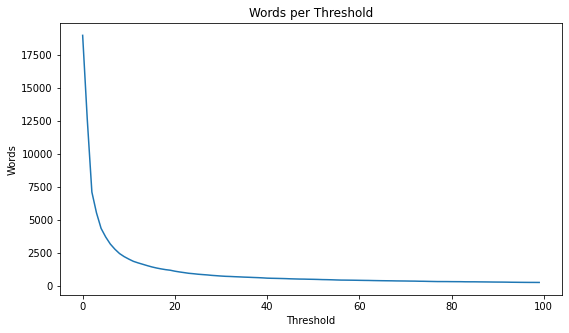

In [ ]:
fig = plt.figure(figsize=(9,5))
ax = fig.add_subplot(1, 1, 1)
line1 = ax.plot(word_trend)
# line2 = ax.plot(history[2])
ax.set_title('Words per Threshold')
ax.set_ylabel('Words')
ax.set_xlabel('Threshold')
# ax.legend(('Train Loss', 'Val Loss'))
# plt.savefig('Model[Units{}Epochs{}Run{}]Loss'.format(units, EPOCHS, run))

In [ ]:
to_remove = []
for wrd in voc.keys():
  if wrd not in keep_list:
    if wrd not in enc_dict:
      to_remove.append(wrd)

In [ ]:
questions, answers = remove_bad(questions, answers, to_remove)

In [ ]:
questions, answers = limit_range(questions, answers, 5)

In [ ]:
for i in range(len(questions)):
  questions[i] = '<start> ' + questions[i] + ' <end>'
  answers[i] = '<start> ' + answers[i] + ' <end>'

In [ ]:
from sklearn.model_selection import train_test_split

def tokenize(lang):
        
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', oov_token='<OOV>')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang) 

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

  return tensor, lang_tokenizer

BUFFER_SIZE = 500
BATCH_SIZE = 100

input_tensor, inp_lang = tokenize(questions)
target_tensor, targ_lang = tokenize(answers)

input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.1)

train_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

val_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val))
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
len(questions)
num_examples = MAX_SAMPLES

In [ ]:
example_input_batch, example_target_batch = next(iter(train_dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([100, 7]), TensorShape([100, 7]))

In [ ]:
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1
max_length_input = example_input_batch.shape[1]
max_length_output = example_target_batch.shape[1]

units = 1024
steps_per_epoch = num_examples//BATCH_SIZE

In [ ]:
print("max_length_input, max_length_target, vocab_size_input, vocab_size_target")
max_length_input, max_length_output, vocab_inp_size, vocab_tar_size

max_length_input, max_length_target, vocab_size_input, vocab_size_target


(7, 7, 1070, 1067)

In [ ]:
embeddings_index = {}
with open('/content/drive/MyDrive/Dati/glove.6B.50d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float16')
        embeddings_index[word] = coefs
    f.close()

print("Glove Loded!")

Glove Loded!


In [ ]:
embedding_dimention = 50

embedding_matrix_enc = np.zeros((len(inp_lang.word_index)+1, embedding_dimention))
for word, i in inp_lang.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all-zeros.
        embedding_matrix_enc[i] = embedding_vector
embed_enc = Embedding(len(inp_lang.word_index)+1, 
              50, 
              input_length=max_length_input,
              trainable=True)

embed_enc.build((None,))
embed_enc.set_weights([embedding_matrix_enc])

In [ ]:
embedding_matrix_dec = np.zeros((len(targ_lang.word_index)+1, embedding_dimention))
for word, i in targ_lang.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all-zeros.
        embedding_matrix_dec[i] = embedding_vector
embed_dec = Embedding(len(targ_lang.word_index)+1, 
              50, 
              
              input_length=max_length_output,
              trainable=True)

embed_dec.build((None,))
embed_dec.set_weights([embedding_matrix_dec])

In [ ]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_layer, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    # self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.embedding = embedding_layer
    ##-------- LSTM layer in Encoder ------- ##
    self.lstm_layer = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform'
                                   ))
    


  def call(self, x, hidden):
    x = self.embedding(x)
    output, fh, fc, bh, bc = self.lstm_layer(x, initial_state = hidden)

    h = Concatenate()([fh, bh])
    c = Concatenate()([fc, bc])
    return output, h, c

  def initialize_hidden_state(self):
    return [tf.zeros((self.batch_sz, self.enc_units)) for i in range(4)] 

In [ ]:
## Test Encoder Stack

encoder = Encoder(vocab_inp_size, embed_enc, units, BATCH_SIZE)


# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_h, sample_c = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder h vecotr shape: (batch size, units) {}'.format(sample_h.shape))
print ('Encoder c vector shape: (batch size, units) {}'.format(sample_c.shape))

Encoder output shape: (batch size, sequence length, units) (100, 7, 2048)
Encoder h vecotr shape: (batch size, units) (100, 2048)
Encoder c vector shape: (batch size, units) (100, 2048)


In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_layer, dec_units, batch_sz, attention_type='luong'):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.attention_type = attention_type
    
    # Embedding Layer
    # self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.embedding = embedding_layer
    
    #Final Dense layer on which softmax will be applied
    self.fc = tf.keras.layers.Dense(vocab_size)

    # Define the fundamental cell for decoder recurrent structure
    self.decoder_rnn_cell = tf.keras.layers.LSTMCell(self.dec_units)
   


    # Sampler
    # self.sampler = tfa.seq2seq.sampler.TrainingSampler()
    self.sampler = tfa.seq2seq.sampler.ScheduledEmbeddingTrainingSampler(sampling_probability=0.1, embedding_fn=self.embedding) ###

    # Create attention mechanism with memory = None
    self.attention_mechanism = self.build_attention_mechanism(self.dec_units, 
                                                              None, self.batch_sz*[max_length_input], self.attention_type)

    # Wrap attention mechanism with the fundamental rnn cell of decoder
    self.rnn_cell = self.build_rnn_cell(batch_sz)

    # Define the decoder with respect to fundamental rnn cell
    self.decoder = tfa.seq2seq.BasicDecoder(self.rnn_cell, sampler=self.sampler, output_layer=self.fc)

    
  def build_rnn_cell(self, batch_sz):
    rnn_cell = tfa.seq2seq.AttentionWrapper(self.decoder_rnn_cell, 
                                  self.attention_mechanism, attention_layer_size=self.dec_units)
    return rnn_cell

  def build_attention_mechanism(self, dec_units, memory, memory_sequence_length, attention_type='luong'):
    # ------------- #
    # typ: Which sort of attention (Bahdanau, Luong)
    # dec_units: final dimension of attention outputs 
    # memory: encoder hidden states of shape (batch_size, max_length_input, enc_units)
    # memory_sequence_length: 1d array of shape (batch_size) with every element set to max_length_input (for masking purpose)

    if(attention_type=='bahdanau'):
      return tfa.seq2seq.BahdanauAttention(units=dec_units, memory=memory, memory_sequence_length=memory_sequence_length)
    else:
      return tfa.seq2seq.LuongAttention(units=dec_units, memory=memory, memory_sequence_length=memory_sequence_length)

  def get_attention_weights(self):
    w = self.rnn_cell.weights
    return w
  def build_initial_state(self, batch_sz, encoder_state, Dtype):
    decoder_initial_state = self.rnn_cell.get_initial_state(batch_size=batch_sz, dtype=Dtype)
    decoder_initial_state = decoder_initial_state.clone(cell_state=encoder_state)
    return decoder_initial_state


  def call(self, inputs, initial_state):
    x = self.embedding(inputs)
    outputs, _, _ = self.decoder(x, initial_state=initial_state, sequence_length=self.batch_sz*[max_length_output-1])
    
    return outputs

In [ ]:
# Test decoder stack

decoder = Decoder(vocab_tar_size, embed_dec, units*2, BATCH_SIZE, 'luong')
sample_x = tf.random.uniform((BATCH_SIZE, max_length_output))
decoder.attention_mechanism.setup_memory(sample_output)
initial_state = decoder.build_initial_state(BATCH_SIZE, [sample_h, sample_c], tf.float32)


sample_decoder_outputs = decoder(sample_x, initial_state)

print("Decoder Outputs Shape: ", sample_decoder_outputs.rnn_output.shape)


Decoder Outputs Shape:  (100, 6, 1067)


##Training

In [ ]:
def loss_function(real, pred):
  # real shape = (BATCH_SIZE, max_length_output)
  # pred shape = (BATCH_SIZE, max_length_output, tar_vocab_size )
  cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
  loss = cross_entropy(y_true=real, y_pred=pred)
  mask = tf.logical_not(tf.math.equal(real,0))   #output 0 for y=0 else output 1
  mask = tf.cast(mask, dtype=loss.dtype)  
  loss = mask* loss
  loss = tf.reduce_mean(loss)
  return loss  

In [ ]:
from keras import backend as K
def accuracy_function(real, pred):
  y_pred = pred
  y_true = real
  pred_values = K.cast(K.argmax(y_pred, axis=-1), dtype='int32')
  correct = K.cast(K.equal(y_true, pred_values), dtype='float32')

  mask = K.cast(K.greater(y_true, 0), dtype='float32')
  n_correct = K.sum(mask * correct)
  n_total = K.sum(mask)
  accuracy = n_correct/n_total
  accuracy = tf.reduce_mean(accuracy)
  return accuracy

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
!rm -r /content/training_checkpoints/

rm: cannot remove '/content/training_checkpoints/': No such file or directory


In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0
  with tf.GradientTape() as tape:
    enc_output, enc_h, enc_c = encoder(inp, enc_hidden)


    dec_input = targ[ : , :-1 ] # Ignore <end> token
    real = targ[ : , 1: ]         # ignore <start> token

    decoder.attention_mechanism.setup_memory(enc_output)

    decoder_initial_state = decoder.build_initial_state(BATCH_SIZE, [enc_h, enc_c], tf.float32)
    pred= decoder(dec_input, decoder_initial_state)
    logits = pred.rnn_output
    loss = loss_function(real, logits)
    accuracy = accuracy_function(real, logits)

  variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))

  return loss, accuracy

In [ ]:
@tf.function
def val_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_h, enc_c = encoder(inp, enc_hidden)


    dec_input = targ[ : , :-1 ] # Ignore <end> token
    real = targ[ : , 1: ]         # ignore <start> token

    decoder.attention_mechanism.setup_memory(enc_output)

    decoder_initial_state = decoder.build_initial_state(BATCH_SIZE, [enc_h, enc_c], tf.float32)
    pred= decoder(dec_input, decoder_initial_state)
    logits = pred.rnn_output
    loss = loss_function(real, logits)
    accuracy = accuracy_function(real, logits)

  return loss, accuracy

In [ ]:
run = 0

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
EPOCHS = 100
train_loss_vec = []
train_accuracy_vec = []
val_loss_vec = []
val_accuracy_vec = []
time_vec = []
run += 1
print('---TRAINING PHASE---\n')
print('MODEL: UNITS {} EPOCHS {} RUN {}'.format(units, EPOCHS, run))
start_training = time.time()
with tf.device('/gpu:0'):
  for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_train_loss = 0
    total_train_accuracy = 0
    total_val_loss = 0
    total_val_accuracy = 0
    

    for (batch, (inp, targ)) in enumerate(train_dataset.take(steps_per_epoch)):
      train_loss, train_accuracy = train_step(inp, targ, enc_hidden)
      total_train_loss += train_loss
      total_train_accuracy += train_accuracy


    train_loss_vec.append('{:.4f}'.format(total_train_loss / steps_per_epoch))
    train_accuracy_vec.append('{:.4f}'.format(total_train_accuracy / steps_per_epoch))
      
    for (batch, (inp, targ)) in enumerate(val_dataset.take(steps_per_epoch)):
      val_loss, val_accuracy = val_step(inp, targ, enc_hidden)
      total_val_loss += val_loss
      total_val_accuracy += val_accuracy

      
    val_loss_vec.append('{:.4f}'.format(total_val_loss / steps_per_epoch))
    val_accuracy_vec.append('{:.4f}'.format(total_val_accuracy / steps_per_epoch))


    
    if (epoch + 1) % 20 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch: {} | Loss: {:.4f} | Accuracy: {:.4f} | Val Loss: {:.4f} | Val Accuracy: {:.4f}'.format(epoch + 1,
                                        total_train_loss / steps_per_epoch,
                                        total_train_accuracy / steps_per_epoch,
                                        total_val_loss / steps_per_epoch,
                                        total_val_accuracy / steps_per_epoch
                                        ))
    
    epoch_time = time.time() - start
    time_vec.append(epoch_time)
    print('Time taken for epoch {} {} sec\n'.format(epoch +1 , epoch_time))
  total_time = time.time() - start_training
  print('Time taken for the whole training phase is: {} sec'.format(total_time))



---TRAINING PHASE---

MODEL: UNITS 1024 EPOCHS 100 RUN 1
Epoch: 1 | Loss: 3.5535 | Accuracy: 0.2179 | Val Loss: 0.3536 | Val Accuracy: 0.0291
Time taken for epoch 1 20.91599941253662 sec

Epoch: 2 | Loss: 3.0567 | Accuracy: 0.2792 | Val Loss: 0.3336 | Val Accuracy: 0.0332
Time taken for epoch 2 10.06523323059082 sec

Epoch: 3 | Loss: 2.9162 | Accuracy: 0.2968 | Val Loss: 0.3258 | Val Accuracy: 0.0340
Time taken for epoch 3 10.083886623382568 sec

Epoch: 4 | Loss: 2.8239 | Accuracy: 0.3058 | Val Loss: 0.3230 | Val Accuracy: 0.0347
Time taken for epoch 4 10.292307615280151 sec

Epoch: 5 | Loss: 2.7478 | Accuracy: 0.3117 | Val Loss: 0.3236 | Val Accuracy: 0.0350
Time taken for epoch 5 10.09179425239563 sec

Epoch: 6 | Loss: 2.6792 | Accuracy: 0.3163 | Val Loss: 0.3238 | Val Accuracy: 0.0344
Time taken for epoch 6 10.104376554489136 sec

Epoch: 7 | Loss: 2.6046 | Accuracy: 0.3218 | Val Loss: 0.3295 | Val Accuracy: 0.0338
Time taken for epoch 7 10.050174474716187 sec

Epoch: 8 | Loss: 2.515

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
f=open('History{}Units{}Epochs{}Run.txt'.format(units, EPOCHS, run),'w')
# f.write('Total time:\t' + str(total_time) + '\t' + 'sec' + '\n')
f.write('TrainLoss\t' + 'TrainAccuracy\t' + 'ValLoss\t' + 'ValAccuracy\t' + 'Time\n')
for e in range(len(train_loss_vec)):
    f.write(train_loss_vec[e]+'\t'+ train_accuracy_vec[e]+ '\t' + val_loss_vec[e]+ '\t' + val_accuracy_vec[e]+ '\t' + str(time_vec[e]) + '\n')


f.close()

In [ ]:
history = [[],[],[],[], []]
with open('History{}Units{}Epochs{}Run.txt'.format(units, EPOCHS, run)) as infile:
  next(infile)
  for line in infile:
        history[0].append(float(line.split()[0]))
        history[1].append(float(line.split()[1]))
        history[2].append(float(line.split()[2]))
        history[3].append(float(line.split()[3]))
        history[4].append(float(line.split()[4]))

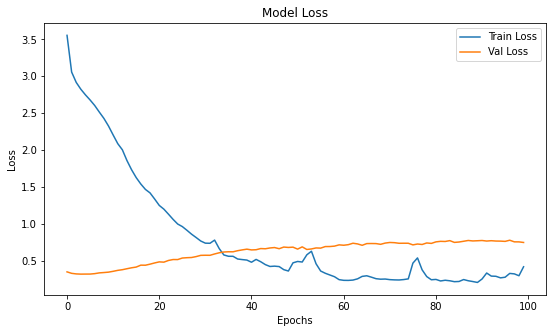

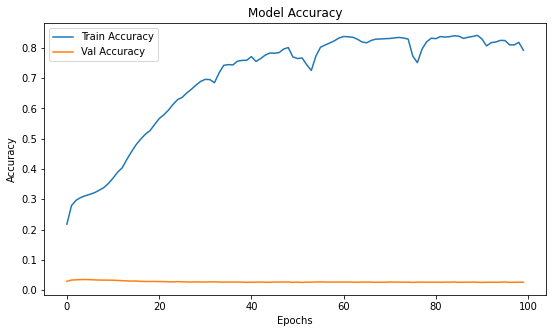

In [ ]:
#Model Loss
fig = plt.figure(figsize=(9,5))
ax = fig.add_subplot(1, 1, 1)
line1 = ax.plot(history[0])
line2 = ax.plot(history[2])
ax.set_title('Model Loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Epochs')
ax.legend(('Train Loss', 'Val Loss'))
plt.savefig('Model[Units{}Epochs{}Run{}]Loss'.format(units, EPOCHS, run))

#Model Accuracy
fig = plt.figure(figsize=(9,5))
ax = fig.add_subplot(1, 1, 1)
line1 = ax.plot(history[1])
line2 = ax.plot(history[3])
ax.set_title('Model Accuracy')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epochs')
ax.legend(('Train Accuracy', 'Val Accuracy'))
plt.savefig('Model[Units{}Epochs{}Run{}]Accuracy'.format(units, EPOCHS, run))

##Inference

In [ ]:
def preprocess_sentence(sentence):

  sentence = prep_sent(sentence)
  sentence = '<start> ' + sentence + ' <end>'
  return sentence

In [ ]:
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(5,5))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [ ]:
def evaluate_sentence(sentence):
  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                          maxlen=max_length_input,
                                                          padding='post')
  inputs = tf.convert_to_tensor(inputs)
  inference_batch_size = inputs.shape[0]
  result = ''

  enc_start_state = [tf.zeros((inference_batch_size, units)) for i in range(4)] # check
  enc_out, enc_h, enc_c = encoder(inputs, enc_start_state)

  dec_h = enc_h
  dec_c = enc_c

  start_tokens = tf.fill([inference_batch_size], targ_lang.word_index['<start>'])
  end_token = targ_lang.word_index['<end>']

  emb_sampler = tfa.seq2seq.SampleEmbeddingSampler()

  decoder_instance = tfa.seq2seq.BasicDecoder(cell=decoder.rnn_cell, sampler=emb_sampler, output_layer=decoder.fc)

  decoder.attention_mechanism.setup_memory(enc_out)

  decoder_initial_state = decoder.build_initial_state(inference_batch_size, [enc_h, enc_c], tf.float32)

  decoder_embedding_matrix = decoder.embedding.variables[0]
  
  outputs, _, _  = decoder_instance(decoder_embedding_matrix, start_tokens = start_tokens, end_token= end_token, initial_state=decoder_initial_state)
  attentions = decoder.get_attention_weights()

  return outputs.sample_id.numpy(), attentions

def translate(sentence):
  result, attention_plot = evaluate_sentence(sentence)
  plot = [attention_plot[i].numpy() for i in range(len(attention_plot))]

  result = targ_lang.sequences_to_texts(result)
  result_cast = str(result[0]).split(' ')
  sentence_cast = sentence.split(' ')

  print('Chatbot Output: {}'.format(result[0]))

  len_res = len(result_cast)
  len_sent = len(sentence_cast)
  plt = plot
  plot = plot[0][:len_res, :len_sent]
  plot_attention(plot, sentence_cast, result_cast)
  print('----------------------------')

In [ ]:

class ChatBot:
  exit_commands = ("quit", "pause", "exit", "goodbye", "bye", "later", "stop")
  def start_chat(self):
    user_response = input("Hello, I am T-800. How can I destroy you?\n")
    
    self.chat(user_response)

  def chat(self, reply):
    while not self.make_exit(reply):
      reply = input(str(translate(reply))+"\n")
    

  def make_exit(self, reply):
    for exit_command in self.exit_commands:
      if exit_command in reply:
        print("Ok, see you in Matrix!")
        return True
    return False
  
chatbot = ChatBot()

## Dialogue

Hello, I am T-800. How can I destroy you?
Hello 
Chatbot Output: you been here with you <end>


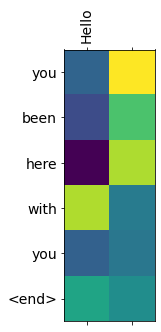

----------------------------
None
What's your name?
Chatbot Output: yes , sir . . <end>


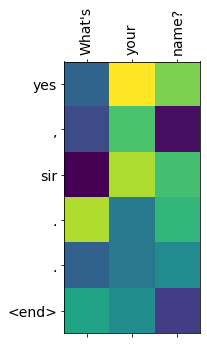

----------------------------
None
How are you?
Chatbot Output: with not think i am <end>


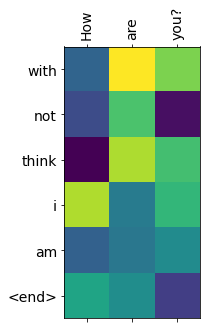

----------------------------
None
Are you alive?
Chatbot Output: i want to see in <end>


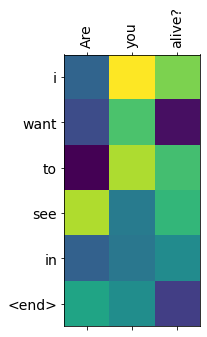

----------------------------
None
Do you believe in god?
Chatbot Output: yes , we can ? <end>


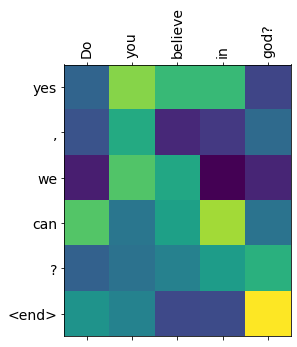

----------------------------
None
Are we alone?
Chatbot Output: yes . <end>


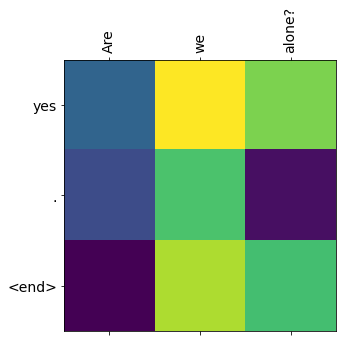

----------------------------
None
Do you love me?
Chatbot Output: i asked love you . <end>


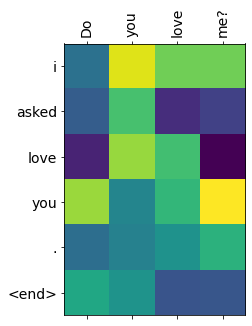

----------------------------
None
I am your father
Chatbot Output: a . <end>


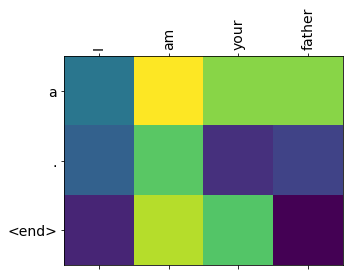

----------------------------
None
bye
Ok, see you in Matrix!


In [ ]:
chatbot.start_chat()

Chatbot Output: i have seen nick i <end>


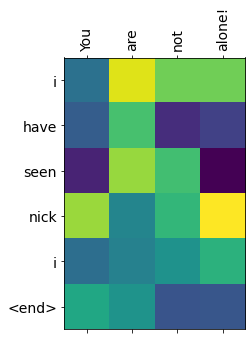

----------------------------

Chatbot Output: did they down the mother <end>


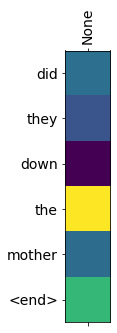

----------------------------

Chatbot Output: the land were you know <end>


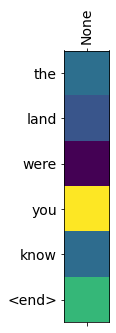

----------------------------

Chatbot Output: did they find it ? <end>


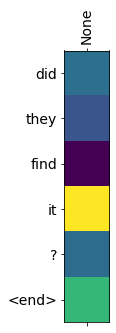

----------------------------

Chatbot Output: what is it ? <end>


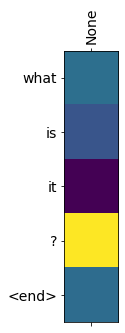

----------------------------



In [ ]:
# feed the model with its previous output
sentence = 'You are not alone!'
for _ in range(5):
  sentence = str(translate(sentence))
  print('')